<a href="https://colab.research.google.com/github/basmala-kamal/tut-pricing-model/blob/main/dry_oil_tut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install requests beautifulsoup4


In [ ]:
pip install robustbase

  Preparing metadata (setup.py) ... done
  Created wheel for statistics: filename=statistics-1.0.3.5-py3-none-any.whl size=7435 sha256=d89318bcd6a971b4161e9d7878bb6dfa2b5a3c4621a2090b5ff8344a00da7ebf
  Stored in directory: /root/.cache/pip/wheels/a7/30/34/fceae1c718a4e749dd51f479c5720c0671519887e824915e90
Successfully built statistics


In [1]:
import requests
from bs4 import BeautifulSoup
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import numpy as np
from sklearn.preprocessing import MinMaxScaler



In [2]:
import json
import pandas as pd
import re

# 1. Load the JSON file
with open("/content/dry+oil+for+body+moisture.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to a pandas DataFrame for easier data manipulation
df = pd.DataFrame(data)
df = df.dropna(subset=["price"])
import time


# Define the function to scrape the brand name
def scrape_brand_name(session, url):
    try:
        if not url or not url.startswith("http"):  # Validate URL
            return None

        # Send a GET request to the URL using the session
        response = session.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP issues

        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(response.content, "html.parser")

        # Adjust this selector based on the actual structure of the webpage
        brand_tag = soup.find("tr", class_="a-spacing-small po-brand")
        if brand_tag:
            td_tag = brand_tag.find("td", class_="a-span9")
            if td_tag:
                span_tag = td_tag.find("span", class_="a-size-base po-break-word")
                if span_tag:
                    return span_tag.get_text(strip=True)

        # Return None if the brand name is not found
        return None

    except requests.exceptions.RequestException as e:
        print(f"Network error scraping {url}: {e}")
        return None
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

# Load the JSON file

"""
# Ensure the 'link' column exists and is valid
if "link" in df.columns:
    # Create a requests session
    with requests.Session() as session:
        # Set a User-Agent header to mimic a browser (optional but recommended)
        session.headers.update({
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
        })

        # Apply the scraping function to the 'link' column
        brand_names = []
        for idx, url in enumerate(df["link"]):
            print(f"Scraping {idx + 1}/{len(df)}: {url}")
            brand_name = scrape_brand_name(session, url)
            brand_names.append(brand_name)

            # Throttle requests to avoid getting blocked
            time.sleep(2)

        # Add the scraped brand names to the DataFrame
        df["brand_name"] = brand_names"""

def clean_price(price_str):
    if price_str is None:
        return None
    numeric_str = re.sub(r"[^\d\.]", "", price_str)
    try:
        return float(numeric_str)
    except ValueError:
        return None

df["price_numeric"] = df["price"].apply(clean_price)


def clean_rating(rating_str):
    if rating_str is None:
        return None

    match = re.search(r"\d+(\.\d+)?", rating_str)
    if match:
        try:
            return float(match.group(0))
        except ValueError:
            return None
    return None

df["rating_numeric"] = df["rating"].apply(clean_rating)

def extract_volume(title_str):
    # Check for "ml" first to avoid misidentification
    match_ml = re.search(r'(\d+(?:\.\d+)?)\s*ml', title_str, re.IGNORECASE)
    if match_ml:
        return float(match_ml.group(1))  # Prioritize ml if present
    else:
    # Check for "oz" (fluid ounces)
      match_oz = re.search(r'(\d+(?:\.\d+)?)\s*(?:fl\.?\s*oz|oz|fluid ounces?)', title_str, re.IGNORECASE)
      if match_oz:
         return float(match_oz.group(1)) * 29.5735  # Convert oz to ml

    # If no match, return None
    return None


# Apply the function to the DataFrame
df["volume"] = df["title"].apply(extract_volume)

def remove_duplicates_by_name_and_price(df):
    # Sort the DataFrame to keep the first occurrence of each duplicate
    df = df.sort_values(by=["title", "price_numeric"])

    # Drop duplicates based on 'name' and 'price_numeric'
    df = df.drop_duplicates(subset=["title", "price_numeric"], keep="first")

    return df

# Apply the duplicate removal function to the DataFrame
df = remove_duplicates_by_name_and_price(df)
# ------------------------------------------------------------------------------
# Final cleaned DataFrame
df = df[~df["title"].str.contains("Cream|Virgin|Wells|Hair|hair|cleansing|cream|serum|balm|Serum|Cleansing", na=False)]
print(df)


                                                 title       price  \
230  2PCS Collagen Plus Lifting Body Oil,Anti-Aging...   SAR 63.95   
99                      A3 Lemon Moisturising Body Oil   SAR 66.57   
302                           ACEITE Body Oils, 0.1 ml   SAR 41.29   
191  ANISSA Natural Cosmetics Body Oil 100 ml for S...  SAR 160.25   
300  AOAO PEGO Stretch Mark Oil Pregnancy Body Oil ...  SAR 266.54   
..                                                 ...         ...   
100  juno & me Dry Touch Body Oil: Body Oil with Dr...  SAR 120.61   
41   lavera Beauty Body Oil - Smooth Skin Complexio...   SAR 80.10   
209  pureSCRUBS Ultra Moisturizing JASMINE BODY OIL...  SAR 201.00   
441  sapér Castor Oil Roller Glass Bottle For Eyebr...   SAR 84.78   
265  velona Jojoba Oil - 16 oz | 100% Pure and Natu...  SAR 140.02   

                 rating                                               link  \
230                None  https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...   
99 

In [3]:
df

,title,price,rating,link,price_numeric,rating_numeric,volume
230,"2PCS Collagen Plus Lifting Body Oil,Anti-Aging...",SAR 63.95,None,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,63.95,NaN,30.000000
99,A3 Lemon Moisturising Body Oil,SAR 66.57,3.9 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,66.57,3.9,NaN
302,"ACEITE Body Oils, 0.1 ml",SAR 41.29,4.6 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,41.29,4.6,0.100000
191,ANISSA Natural Cosmetics Body Oil 100 ml for S...,SAR 160.25,4.7 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,160.25,4.7,100.000000
300,AOAO PEGO Stretch Mark Oil Pregnancy Body Oil ...,SAR 266.54,3.8 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,266.54,3.8,60.034205
...,...,...,...,...,...,...,...
100,juno & me Dry Touch Body Oil: Body Oil with Dr...,SAR 120.61,4.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,120.61,4.0,NaN
41,lavera Beauty Body Oil - Smooth Skin Complexio...,SAR 80.10,4.8 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,80.10,4.8,100.000000
209,pureSCRUBS Ultra Moisturizing JASMINE BODY OIL...,SAR 201.00,4.3 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,201.00,4.3,118.294000
441,sapér Castor Oil Roller Glass Bottle For Eyebr...,SAR 84.78,4.2 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,84.78,4.2,NaN


In [4]:
def adjust_price_for_sets(df):
    def update_price(row):
        title = row["title"]

        # Case 1: Contains 'Set' and 'Pieces'
        if "set" in title.lower() and "pieces" in title.lower():
            match = re.search(r'(\d+)\s*pieces?', title, re.IGNORECASE)
            if match:
                num_items = int(match.group(1))
                if num_items > 0 and pd.notna(row["price_numeric"]):
                    return row["price_numeric"] / num_items

        # Case 2: Contains '2-pack' or '2 bottles'
        if re.search(r'(2-pack|two-pack|2 bottles|two bottles)', title, re.IGNORECASE):
            if pd.notna(row["price_numeric"]):
                return row["price_numeric"] / 2

        # Case 3: Matches formats like '3 bottles', '4 pack', '5 count'
        match = re.search(r'(\d+)\s*(?:bottles|packs?|count)', title, re.IGNORECASE)
        if match:
            num_items = int(match.group(1))
            if num_items > 0 and pd.notna(row["price_numeric"]):
                return row["price_numeric"] / num_items

        # If no adjustments, return the original price
        return row["price_numeric"]

    # Apply the function to the 'price_numeric' column
    df["price_numeric"] = df.apply(update_price, axis=1)
    return df

# Apply the function to your DataFrame
df = adjust_price_for_sets(df)

# Example: Verify with updated rows that match 'Set', '2-pack', or '2 bottles'
print(df[df["title"].str.contains("set|2-pack|bottles", case=False)])

                                                 title       price  \
331  Advanced Clinicals Firming Collagen Body Oil S...  SAR 218.00   
188  Dalan d'Olive Spray Bottle Body Oil 2 x 200 ml...  SAR 114.60   
163  De La Cruz Vitamin E Oil for Skin, Face and Bo...   SAR 88.00   
217  EO Body Oil for Massage & Moisture, French Lav...  SAR 223.00   
211  HUME SUPERNATURAL Dry Body Oil Spray - Moistur...  SAR 323.15   
70   Hume Supernatural Dry Body Oil Spray - Body Mo...  SAR 220.20   
340  Instituto Español Almond Body Oil, Smoothness ...  SAR 120.21   
46   Neutrogena Lightweight Body Oil for Dry Skin, ...  SAR 225.73   
146  Ora's Amazing Herbal Travel Size Body Oil, Bod...  SAR 134.50   
231  Palmer's Cocoa Butter Skin Therapy Oil 150ml +...  SAR 118.82   

                 rating                                               link  \
331  4.5 out of 5 stars  https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...   
188  4.4 out of 5 stars  https://www.amazon.sa/-/en/sspa/click?ie=UTF8&..

In [5]:
df_cleaned = (
    df[["title", "price_numeric", "volume"]]
    .dropna(subset=["title", "price_numeric","volume"])
)

df_cleaned.shape


(176, 3)

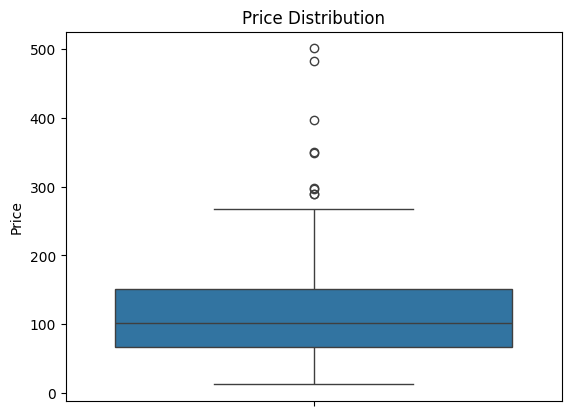

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(y=df_cleaned['price_numeric'])  # Boxplot of price
plt.title('Price Distribution')
plt.ylabel('Price')
plt.show()


In [7]:
import pandas as pd

# Compute Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_cleaned['price_numeric'].quantile(0.25)
Q3 = df_cleaned['price_numeric'].quantile(0.75)

# Compute IQR
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
outliers_df = df_cleaned[(df_cleaned['price_numeric'] < lower_bound) | (df_cleaned['price_numeric'] > upper_bound)]

# Display the outliers
print(outliers_df)


                                                 title  price_numeric  \
279  BOOMING BOB BODY OIL, COCONUT MOISTURE & SOOTH...         501.00   
214            Clarins Tonic Body Treatment Oil 100 ml         350.00   
246  EO Laboratorie natural & organic Nourishing Dr...         483.00   
431            Grown Alchemist Pure Rosehip Oil (25ml)         397.03   
139  Kiehl's Creme de Corps Nourishing Dry Body Oil...         348.97   
38   Kiehl's Creme de Corps Nourishing Dry Body Oil...         289.00   
125  LOLLIA Dry Body Oil, 6.8 Fl. Oz. – Women’s Bod...         298.13   
79   OSEA Undaria Algae Body Oil 5 oz, After Shower...         296.03   
354  PINO Massage Oil - Lime Bamboo Body Oil - 3.4 ...         289.02   

       volume  
279   89.0000  
214  100.0000  
246  200.0000  
431   25.0000  
139  175.0000  
38   175.0000  
125  201.0998  
79   147.8675  
354  100.5499  


In [8]:
df_cleaned = df_cleaned[(df_cleaned['price_numeric'] >= lower_bound) & (df_cleaned['price_numeric'] <= upper_bound)]


In [9]:
scaler = MinMaxScaler()
df_scaled = df_cleaned.copy()  # Keep a copy of the original data/
df_scaled['price_scaled'] = scaler.fit_transform(df_scaled[['price_numeric']])
print(df_scaled)

                                                 title  price_numeric  \
230  2PCS Collagen Plus Lifting Body Oil,Anti-Aging...          63.95   
302                           ACEITE Body Oils, 0.1 ml          41.29   
191  ANISSA Natural Cosmetics Body Oil 100 ml for S...         160.25   
300  AOAO PEGO Stretch Mark Oil Pregnancy Body Oil ...         266.54   
218  Acure Eb1253 The Essentials Marula Oil Usda Or...          56.00   
..                                                 ...            ...   
385  Y-Not Natural Face & Body Oil - Anti-Wrinkle T...         242.00   
396  Yves Rocher, Monoi de Tahiti (100ml): Glitter ...         152.82   
41   lavera Beauty Body Oil - Smooth Skin Complexio...          80.10   
209  pureSCRUBS Ultra Moisturizing JASMINE BODY OIL...         201.00   
265  velona Jojoba Oil - 16 oz | 100% Pure and Natu...         140.02   

         volume  price_scaled  
230   30.000000      0.201401  
302    0.100000      0.112716  
191  100.000000      0.5782

In [ ]:
large = df_scaled[df_scaled["volume"] >=200]
print(large)


                                                 title  price_numeric  \
439  Africa's Best Ultimate Herbal Oil 8 Ounce (235...      44.333333   
16   Aveeno Daily Moisturizing Oil Mist - Dry Skin,...     105.390000   
56   Azonee Essential Oils for Skin, 100% Natural V...      58.500000   
296  B.O.T cosmetic & wellness Vita Oil Anti Stretc...     125.660000   
88                BYOMA BODY Nourishing Body Oil 200ml     105.330000   
244  Beyoutiful Coconut & Lime Body Oil For Kids & ...     262.890000   
76   Bio-Oil Natural Skin Care Oil for Stretch Mark...      79.600000   
81   Blue Nectar Anti Cellulite Body Massage Oil wi...      78.000000   
57   Blue Nectar Body Oil for Women & Men |Bath & B...      68.640000   
295  CD COSMO DESIGNS Glow White Skin Perfector Whi...     170.000000   
387  Cuccio Hydrating Massage Oil 237ml (8oz) - Mil...      96.000000   
174  DERMA B CeraMD Repair Oil, Lightweight Fast Ab...     111.790000   
268                            DRASANVI Body Oil 25

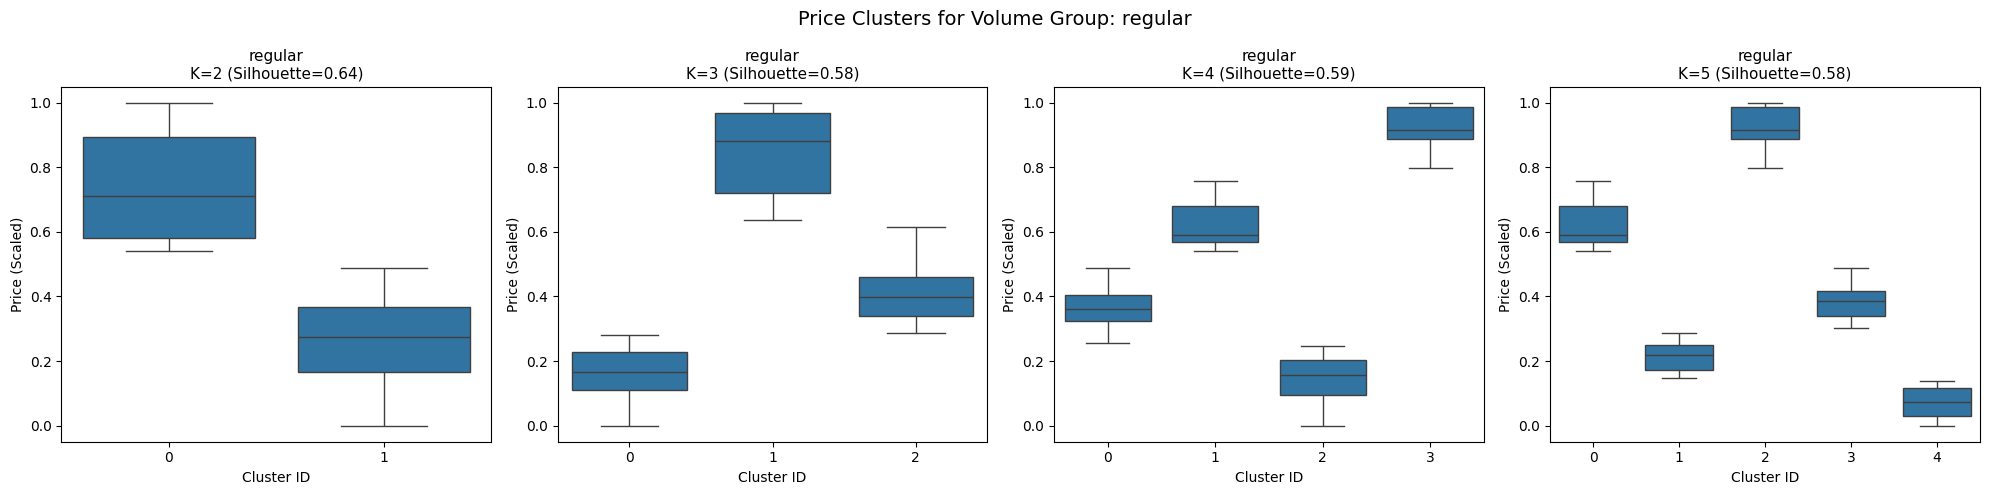

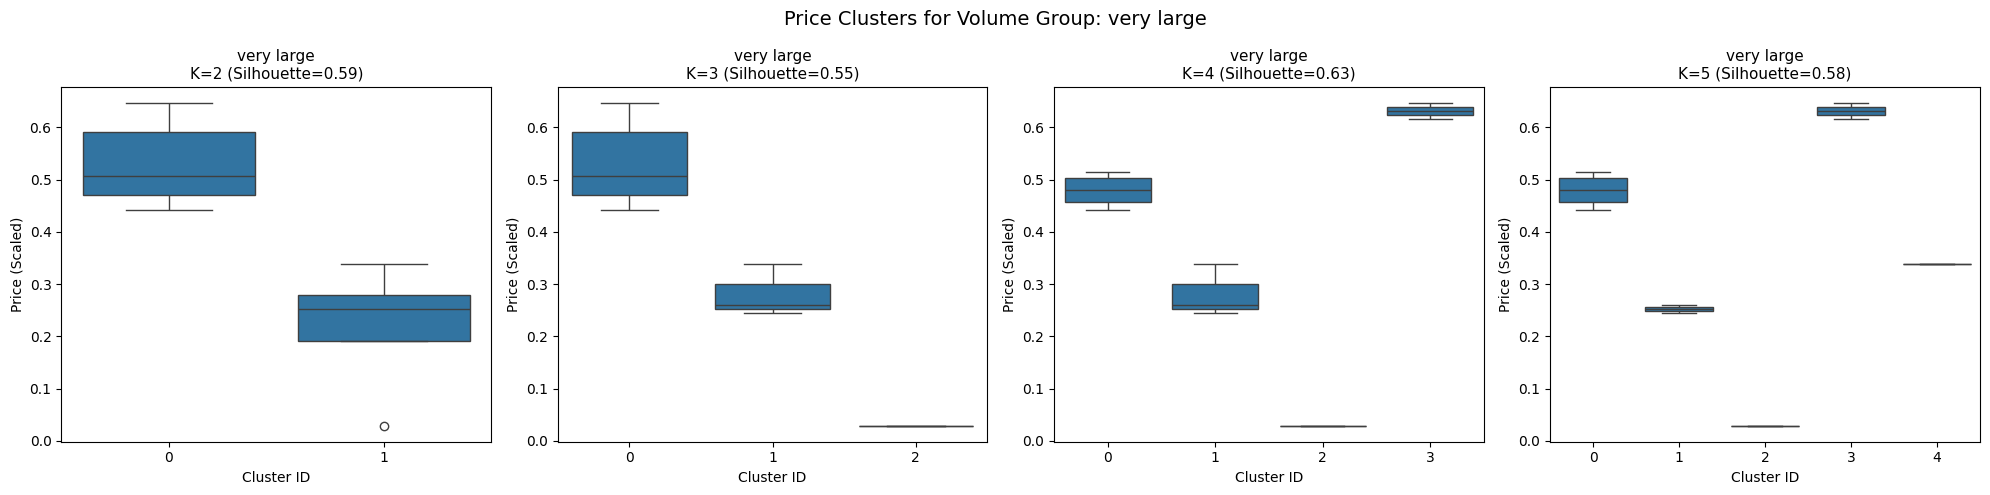

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure no NaNs in required columns
df_scaled = df_scaled.dropna(subset=["volume", "price_scaled"])  # Use price_scaled instead

# 1) Create volume groups
df_scaled["volume_group"] = pd.cut(
    df_scaled["volume"],
    bins=[0, 252, 1000],
    labels=["regular",  "very large"],
    include_lowest=True  # Include 0 in the first group
)

for group_name in df_scaled["volume_group"].unique():
    subset = df_scaled[df_scaled["volume_group"] == group_name].copy()

    if subset.empty:
        print(f"No data for group '{group_name}'. Skipping.")
        continue

    # 2) Use the already scaled price column
    if len(subset) <= 1:
        print(f"Only one row in group '{group_name}'. Skipping clustering.")
        continue

    X_price = subset[["price_scaled"]].values  # Use price_scaled instead of price_numeric

    # Make a figure with 4 subplots
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

    for idx, k in enumerate([2, 3, 4, 5]):
        if len(subset) < k:
            print(f"Skipping k={k} for group '{group_name}' due to insufficient data.")
            continue

        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
        kmeans.fit(X_price)

        # Store cluster labels
        cluster_col = f"cluster_k{k}"
        subset[cluster_col] = kmeans.labels_

        # Silhouette score (handle cases with < 2 clusters)
        if len(subset[cluster_col].unique()) > 1:
            sil_score = silhouette_score(X_price, kmeans.labels_)
        else:
            sil_score = np.nan

        # 3) Visualize via boxplot
        sns.boxplot(
            x=cluster_col,
            y="price_scaled",  # Use price_scaled for visualization
            data=subset,
            ax=axes[idx]
        )
        axes[idx].set_title(
            f"{group_name}\nK={k} (Silhouette={sil_score:.2f})",
            fontsize=11
        )
        axes[idx].set_xlabel("Cluster ID")
        axes[idx].set_ylabel("Price (Scaled)")

    # Save cluster labels back to df_scaled
    for cluster_col in [f"cluster_k{k}" for k in [2, 3, 4,5]]:
        df_scaled.loc[subset.index, cluster_col] = subset[cluster_col]

    plt.suptitle(f"Price Clusters for Volume Group: {group_name}", fontsize=14)
    plt.subplots_adjust(top=0.85)
    plt.tight_layout()
    plt.show()


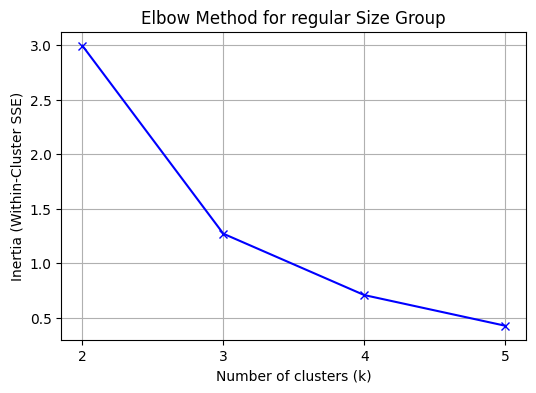

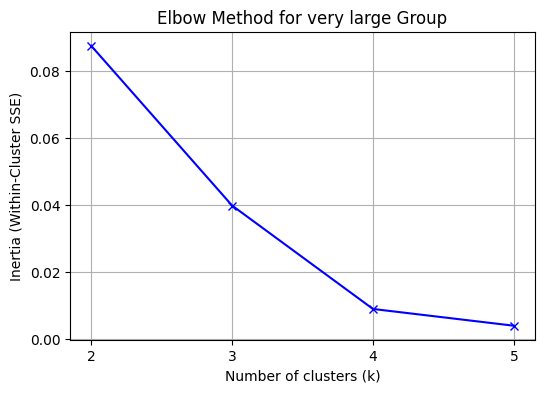

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Process for 'regular' size group
regular_group = df_scaled[df_scaled["volume_group"] == "regular"]
if regular_group.empty:
    print("No data for 'regular' size group. Skipping.")
else:
    # Extract the already scaled price column for clustering
    X_price_regular = regular_group[["price_scaled"]].values  # Use price_scaled instead of price_numeric

    # Skip clustering if there's only one row
    if len(regular_group) <= 1:
        print("Only one row in 'regular' size group. Skipping clustering.")
    else:
        # Elbow method for the regular group
        distortions_regular = []
        K_range = range(2, 6)  # Try k = 2 to 5
        for k in K_range:
            kmeans_temp_regular = KMeans(n_clusters=k, random_state=0, n_init=10)
            kmeans_temp_regular.fit(X_price_regular)
            distortions_regular.append(kmeans_temp_regular.inertia_)

        # Plot Elbow Method for regular group
        plt.figure(figsize=(6, 4))
        plt.plot(K_range, distortions_regular, 'bx-')
        plt.title('Elbow Method for regular Size Group')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Inertia (Within-Cluster SSE)')
        plt.xticks(K_range)  # Show integer ticks
        plt.grid(True)
        plt.show()

# Process for 'very large' group
large_group = df_scaled[df_scaled["volume_group"] == "very large"]
if large_group.empty:
    print("No data for 'very large' group. Skipping.")
else:
    # Extract the already scaled price column for clustering
    X_price_large = large_group[["price_scaled"]].values  # Use price_scaled instead of price_numeric

    # Skip clustering if there's only one row
    if len(large_group) <= 1:
        print("Only one row in 'very large' group. Skipping clustering.")
    else:
        # Elbow method for the very large group
        distortions_large = []
        K_range = range(2, 6)  # Try k = 2 to 5
        for k in K_range:
            kmeans_temp_large = KMeans(n_clusters=k, random_state=0, n_init=10)
            kmeans_temp_large.fit(X_price_large)
            distortions_large.append(kmeans_temp_large.inertia_)

        # Plot Elbow Method for very large group
        plt.figure(figsize=(6, 4))
        plt.plot(K_range, distortions_large, 'bx-')
        plt.title('Elbow Method for very large Group')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Inertia (Within-Cluster SSE)')
        plt.xticks(K_range)  # Show integer ticks
        plt.grid(True)
        plt.show()


In [12]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# 1) Make two volume bins
df_scaled["volume_group"] = pd.cut(
    df_scaled["volume"],
    bins=[0, 252, 1000],
    labels=["regular", "very large"]
)

all_dfs = []

for group_name in ["regular", "very large"]:
    # 2) Subset data for that group using the already scaled price
    subset = df_scaled[df_scaled["volume_group"] == group_name].copy()

    if subset.empty:
        print(f"No data for group '{group_name}'. Skipping.")
        continue

    X_price = subset[["price_scaled"]].values  # Use price_scaled instead of price_numeric

    # 3) Pick k clusters based on group
    k = 3  # Both groups use k=3 as per original logic

    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)

    # Store cluster labels in the subset
    subset["final_cluster"] = kmeans.labels_

    # Collect for concatenation later
    all_dfs.append(subset)

# 4) Combine back into one DataFrame
df_final = pd.concat(all_dfs, ignore_index=True)

# 5) Inspect cluster means, counts, etc.
summary = (
    df_final
    .groupby(["volume_group", "final_cluster"])["price_numeric"]  # Use price_scaled
    .agg(["count", "mean", "min", "max"])
)
print(summary)


                            count        mean     min     max
volume_group final_cluster                                   
regular      0                 64   53.084089   12.49   84.16
             1                 22  227.519545  175.46  268.00
             2                 71  117.892535   85.96  170.11
very large   0                  6  147.978333  125.66  177.81
             1                  3   84.453333   75.15   99.21
             2                  1   20.000000   20.00   20.00


<ipython-input-12-0b2db42d7ec2>:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["volume_group", "final_cluster"])["price_numeric"]  # Use price_scaled


The low price range. Chinese, multi-purpose, saudi natural oils, the one with higher prices are the reputable brands doing private labeling (yet manifacutured in China), the very low prices are for unknown brands

In [13]:
group1 = df_final[
    (df_final["volume_group"] == "regular") &
    (df_final["final_cluster"] == 0)
]
pd.set_option('display.max_colwidth', None)

group1


,title,price_numeric,volume,price_scaled,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
0,"2PCS Collagen Plus Lifting Body Oil,Anti-Aging Collagen Lifting Body Oil,Body Oil for Anti Wrinkles,Firming Body Oil,Moisturizing Body Oil,Collagen Plus Firming Body Oil,Body Oil for Women,30ML",63.950000,30.00000,0.201401,regular,1.0,0.0,2.0,1.0,0
1,"ACEITE Body Oils, 0.1 ml",41.290000,0.10000,0.112716,regular,1.0,0.0,2.0,4.0,0
4,Acure Eb1253 The Essentials Marula Oil Usda Organic 30 Ml,56.000000,30.00000,0.170287,regular,1.0,0.0,2.0,1.0,0
5,"Advanced Clinicals Firming Collagen Body Oil Skin Care Moisturizer | Massage Body Oil | Tighten, Firm, & Hydrate Collagen Oil For Scars, Wrinkles, Crepey Skin, & Stretch Marks, 3.8 Fl Oz",72.000000,112.37930,0.232907,regular,1.0,0.0,2.0,1.0,0
6,Africa's Best Ultimate Herbal Oil 8 Ounce (235ml) (6 Pack),44.333333,235.00000,0.124627,regular,1.0,0.0,2.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...
131,"Shea Moisture Coconut and Hibiscus Bath, Body and Massage Oil, 236 ml",54.920000,236.00000,0.166060,regular,1.0,0.0,2.0,1.0,0
138,Vaseline Illuminate Me Body Oil Created for Melanin Rich Skin Shimmering Body Oil Illuminates Skin with Finishing Touch of Shimmer for Glowing Skin 3.3 oz,61.880000,97.59255,0.193300,regular,1.0,0.0,2.0,1.0,0
139,"Vaseline Intensive Care Body Gel Oil, Cocoa Radiant, 6.8 oz",45.000000,201.09980,0.127236,regular,1.0,0.0,2.0,4.0,0
140,Vaseline Intensive Care Cocoa Radiant Body Gel 200 ml,16.250000,200.00000,0.014716,regular,1.0,0.0,2.0,4.0,0


European made (the low prices are also mass produced asian-manifactured like Avon), but mostly are premium ingredients (natural oils) and purposes

In [15]:
group1 = df_final[
    (df_final["volume_group"] == "regular") &
    (df_final["final_cluster"] == 2)
]
pd.set_option('display.max_colwidth', None)

group1


,title,price_numeric,volume,price_scaled,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
2,ANISSA Natural Cosmetics Body Oil 100 ml for Sensitive Skin Activation Oil Regenerates & Nourishes No Parabens & Animal Testing Vegan & Made in Germany 100% Natural & Skin-Friendly,160.25,100.0000,0.578294,regular,0.0,2.0,1.0,0.0,2
9,Anti-Ageing Premium Cosmetic Body Oil 150 ml - Regenerates and Provides Deep Moisture to the Skin - Fights the Signs of Ageing - 100% Natural - With High-Quality Essential Oils,156.04,150.0000,0.561818,regular,0.0,2.0,1.0,0.0,2
11,"Australian Bodycare Body Oil 80 ml | With Tea Tree against stretch marks, scars or pigment spots | Hydrates & makes the skin elastic | Almond oil, sunflower oil & squalane ensure smooth skin",128.17,80.0000,0.452742,regular,1.0,2.0,0.0,3.0,2
13,"Aveeno Daily Moisturizing Oil Mist - Dry Skin, Sensitive Skin - Oat, Jojoba Oil - Hypoallergenic Body Oil - 200mL",105.39,200.0000,0.363587,regular,1.0,2.0,0.0,3.0,2
14,"Avon Skin So Soft Original Dry Oil Body Spray with Jojoba 150 ml, Pack of 3",152.67,150.0000,0.548628,regular,0.0,2.0,1.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...
148,"Weleda Hydrating Body & Beauty Oil, 3.4 Fl Oz (Pack of 1)",93.74,100.5499,0.317991,regular,1.0,2.0,0.0,3.0,2
149,"Weleda Pregnancy Body Oil for Stretch Marks, 3.4 Fluid Ounce, Clear",119.26,100.5499,0.417870,regular,1.0,2.0,0.0,3.0,2
150,"Weleda Refreshing Citrus Body Oil, 3.4 Fluid Ounce, Plant Rich Body Oil with Lemon Peel and Sweet Almond Oils",99.00,100.5499,0.338578,regular,1.0,2.0,0.0,3.0,2
151,"Weleda Skin Food Body Oil, Ultralight Dry Oil, Vitamin E, Moisturising Oil for Women & Women, 100% Certified Natural, Organic, Dermatologically Tested, 100 ml",85.96,100.0000,0.287543,regular,1.0,2.0,0.0,1.0,2


Similar to the european made cluster but very niche purposes

In [16]:
group1 = df_final[
    (df_final["volume_group"] == "regular") &
    (df_final["final_cluster"] == 1)
]
pd.set_option('display.max_colwidth', None)

group1


,title,price_numeric,volume,price_scaled,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
3,"AOAO PEGO Stretch Mark Oil Pregnancy Body Oil Pregnancy Skin Care Oil to Prevent and Reduce Stretch Marks During Pregnancy, 2.03 oz (1 Pack)",266.54,60.034205,0.994286,regular,0.0,1.0,3.0,2.0,1
8,Alqvimia Body Oil for Firm and Healthy Skin 150ml,241.26,150.000000,0.895347,regular,0.0,1.0,3.0,2.0,1
10,"Au Natural Organics Yangu Oil | Moisturizing Oil for Dry Sensitive Skin | Body Oil & Face Hydrating Moisturizer | All Natural, Cold Pressed Daily Moisturizer for Acne-Prone, Discolorations | 3.4 oz",263.82,100.549900,0.983641,regular,0.0,1.0,3.0,2.0,1
20,"Beyoutiful Coconut & Lime Body Oil For Kids & Teens, Moisturizing Oil That Brightens & Moisturizes All Day With Jojoba And Sweet Almonds, Soft Skin 8 Fl Oz (Pack of 1)",262.89,236.588000,0.980001,regular,0.0,1.0,3.0,2.0,1
21,Bio-Oil Bio Oil Skincare Oil 125ml- Twin Value pack,175.46,125.000000,0.637822,regular,0.0,1.0,1.0,0.0,1
59,First Aid Beauty Nourishing After-Shower Body Oil – Hydrates Skin + Locks In Moisture with Skin-Loving Lipids + Botanicals – Safe for Sensitive Skin – 6 oz,185.54,177.441000,0.677273,regular,0.0,1.0,1.0,0.0,1
61,"Glow Body Oil (120ml) - Body Shine, Lasting Hydration, Body Oil for Radiant Glow, Glow Oil, Body & Face Makeup, Platinum Diamond",241.19,120.000000,0.895073,regular,0.0,1.0,3.0,2.0,1
64,"Hume Supernatural Dry Body Oil Spray - Body Moisture for Dry Skin | Soothing Hydration Dehydrated Skin Reset with 100% Pure Prickly Pear Oil, Paraben, Silicone & Phthalate-Free, Desert Bloom, 4 fl. Oz",220.20,118.294000,0.812923,regular,0.0,1.0,3.0,2.0,1
69,"Jason Naturals Vitamin E 5000 IU Skin Oil (Pack of 2) with Sunflower Oil, Safflower, Rice, Avocado, Sweet Almond, Apricot and Wheat, 4 oz. Each",267.00,118.294000,0.996086,regular,0.0,1.0,3.0,2.0,1
74,"LOLLIA Wish Dry Body Oil, 6.8 Fl Oz",250.50,201.099800,0.931510,regular,0.0,1.0,3.0,2.0,1


Authentic imported ingredients (Indian, European, African-labeled), compared to prices from the regular volume group, the prices are on the mid range market

In [17]:
group1 = df_final[
    (df_final["volume_group"] == "very large") &
    (df_final["final_cluster"] == 0)
]
pd.set_option('display.max_colwidth', None)

group1


,title,price_numeric,volume,price_scaled,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
157,"B.O.T cosmetic & wellness Vita Oil Anti Stretch Marks: Stretch Marks, Firming Body Oil, Fights Skin Sagging by 87%, Improves Skin Complexion (Almonds, Vitamins A E) - 500 ml",125.66,500.0000,0.442918,very large,0.0,0.0,0.0,0.0,0
158,CD COSMO DESIGNS Glow White Skin Perfector Whitening Body Oil 300ml | Effective Skin Lightening Solution | Vitamin E & Grapeseed Oil | Improves Skin Texture | For Men and Women,170.00,300.0000,0.616453,very large,0.0,0.0,3.0,3.0,0
160,"Hydro 2 Oil – Sweet Almond Oil for Body Massage - A Light Non - Greasy, Odourless & Versatile Oil to Soften and Soothe the Skin, Almond oil is ideal for nourishing dry or sensitive skin – 33.8 fl oz",177.81,999.5843,0.647020,very large,0.0,0.0,3.0,3.0,0
162,"PURA D'OR Organic Massage Therapy Oil (16oz) USDA Certified Almond, Apricot, Argan, Ginger, Jojoba, Lavender Oils for Silky & Softer Skin, Body Moisturizer & Skin Lubricant (Packaging May Vary)",144.00,473.1760,0.514696,very large,0.0,0.0,0.0,0.0,0
164,SENSELAB Castor Oil Organic - Made in India - 100% Pure Extract Castor Oil Therapeutic Grade (16 Fl Oz / 473 ml),130.38,473.0000,0.461391,very large,0.0,0.0,0.0,0.0,0
166,"velona Jojoba Oil - 16 oz | 100% Pure and Natural | After Shower Body Oil | Golden, Unrefined, Cold Pressed, Hexane Free",140.02,473.1760,0.499119,very large,0.0,0.0,0.0,0.0,0


having privately labeled imported but low prices compared to their quantities - not very common given the sample size though

In [18]:
group1 = df_final[
    (df_final["volume_group"] == "very large") &
    (df_final["final_cluster"] == 1)
]
pd.set_option('display.max_colwidth', None)

group1


,title,price_numeric,volume,price_scaled,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
161,"Nimson Olive Body Oil | Deep Moisturization, Soothing Relief | Italian Olives, Hydrating Formula | 500ml Bottle | Dry Skin, Radiant Glow, Ethically Sourced",75.15,500.0,0.245235,very large,1.0,1.0,1.0,1.0,1
163,"Rilastil Xerolact - Olio Detergente Protettivo Anti Irritazioni, 750Ml",99.21,750.0,0.339400,very large,1.0,1.0,1.0,4.0,1
165,"Silky Cool Almond and Milk Body Massage Oil - Clear, 500 ml",79.00,500.0,0.260303,very large,1.0,1.0,1.0,1.0,1


American drugstore, clearly an outlier

In [19]:
group1 = df_final[
    (df_final["volume_group"] == "very large") &
    (df_final["final_cluster"] == 2)
]
pd.set_option('display.max_colwidth', None)

group1


,title,price_numeric,volume,price_scaled,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
159,"Dr Teal's Moisturizing Bath & Body Oil, Eucalyptus & Spearmint, 8.8 Fluid Ounce",20.0,260.2468,0.029392,very large,1.0,2.0,2.0,2.0,2
